In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats
from pprint import pprint
import matplotlib.pylab as plt
import re

:0: FutureWarning: IPython widgets are experimental and may change in the future.


In [2]:
%matplotlib inline
sns.set(style="ticks", color_codes=True, font_scale=1.1)

## Introduction

I will analyze the data for Titanic survivors, published as a Kaggle competition few years back, and widely known in the data science community. As a starter, I will raise a few questions that I will answer with data along the exploration:
* What is the age distribution distribution of the passengers?
* How many different families were on board?
* Was there a predominance of single passengers or large families?
* What was the average fare for each class?
* How does each variable impact on the chance of surviving?

The last question is the most relevant, being the original goal of the Kaggle challenge to use this data to predict the chance of a passenger surviving the tragedy, and will be the underlying theme for the data exploration process. 

## Data Overview

In [3]:
# read csv into a dataframe
df = pd.read_csv("titanic_data.csv")

In [4]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
# setting passenger id to be the index
df = df.set_index('PassengerId')
df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [6]:
# showing data types
df.dtypes

Survived      int64
Pclass        int64
Name         object
Sex          object
Age         float64
SibSp         int64
Parch         int64
Ticket       object
Fare        float64
Cabin        object
Embarked     object
dtype: object

In [7]:
df.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


The describe function answers the 1st question we raised regarding the passengers' age distribution. We can see that the mean age is 29 years old, with a standard deviation of 14 years, a min of 0.4 (around 5 months old) and a max of 80. Most of the passengers are between 20 and 40 yers old. We can also see the distribution in a kernel density estimation:

/Users/lucasosouza/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


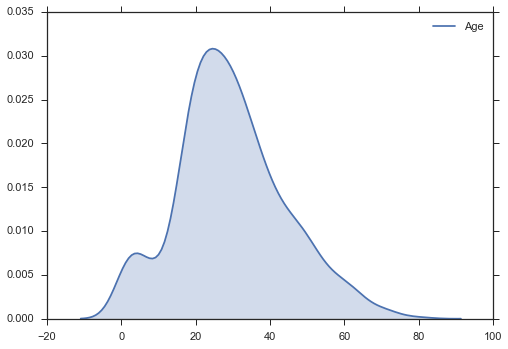

In [8]:
sns.kdeplot(df['Age'], shade=True);

## Dealing with categorical variables

I will take a look at categorical variables, and see how can we convert them into data that will give some relevant information for the analysis.

In [9]:
# show categories for categorical variables
df['Cabin'].value_counts()[:5]

C23 C25 C27    4
G6             4
B96 B98        4
D              3
C22 C26        3
Name: Cabin, dtype: int64

Cabin per see has too much labels. It would be more useful if we can condense this information. The letter probably indicates position on the ship, which might a better indicator of class that Pclass variable, since it has more levels. This new variable will be ordinal, so I will represent as integers instead of actual letters.

In [10]:
def extract_cabin_class(cabin):
    if pd.isnull(cabin):
        return np.nan
    return ord(str(cabin)[0]) - 64

df['Cclass'] = df['Cabin'].apply(extract_cabin_class)
df.ix[:5, ['Cclass', 'Cabin']]

,Cclass,Cabin
PassengerId,,
1,NaN,NaN
2,3.0,C85
3,NaN,NaN
4,3.0,C123
5,NaN,NaN


In [11]:
df['Embarked'].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

There is not much I can do with embarked as of now. It is a nominal value that represents the port of embarkation, so they have no natural order.

In [12]:
df['Ticket'].value_counts()[:5]

CA. 2343    7
347082      7
1601        7
347088      6
CA 2144     6
Name: Ticket, dtype: int64

There are also too much tickets, and no apparent order, so it is hard to convert them to a feature. But they can still be useful for prediction as it is. People with the same tickets probably indicates they are from the same family (or at least the same group), so chances of one of the groups members surviving might affect the rest of the group.

In [13]:
df['Name'].value_counts()[:5]

Graham, Mr. George Edward                              1
Elias, Mr. Tannous                                     1
Madill, Miss. Georgette Alexandra                      1
Cumings, Mrs. John Bradley (Florence Briggs Thayer)    1
Beane, Mrs. Edward (Ethel Clarke)                      1
Name: Name, dtype: int64

There are two useful informations in Name variable: the family names, and the honorific. Let's extract these two into different categorical variables. Family name will have a similar function of ticket, helping to group family members, while honorific is a symbol of social status (higher status can mean higher chance to survive).

In [14]:
def extract_surname(name):
    return name.split(',')[0]

def extract_honorific(name):
    try:
        return re.search('(?<=, )M\w*', name).group(0)
    except: return np.nan

df['Surname'] = df['Name'].apply(extract_surname)
df['Honorific'] = df['Name'].apply(extract_honorific)
df.ix[:5, ['Name', 'Surname', 'Honorific']]

,Name,Surname,Honorific
PassengerId,,,
1,"Braund, Mr. Owen Harris",Braund,Mr
2,"Cumings, Mrs. John Bradley (Florence Briggs Th...",Cumings,Mrs
3,"Heikkinen, Miss. Laina",Heikkinen,Miss
4,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",Futrelle,Mrs
5,"Allen, Mr. William Henry",Allen,Mr


In [15]:
len(df['Surname'].value_counts())

667

In [16]:
# look at new categories
df['Honorific'].value_counts()

Mr        517
Miss      182
Mrs       125
Master     40
Major       2
Mlle        2
Ms          1
Mme         1
Name: Honorific, dtype: int64

We now can answer our 2nd question: considering the dataset is complete, there were 667 different families onboard the Titanic.

## Dealing with null values

In [17]:
# count na values
df.isnull().sum()

Survived       0
Pclass         0
Name           0
Sex            0
Age          177
SibSp          0
Parch          0
Ticket         0
Fare           0
Cabin        687
Embarked       2
Cclass       687
Surname        0
Honorific     21
dtype: int64

Age is an important information, so I will look only at variables which have Age data available. The Cclass column I will remove from the following analysis for now, since two thirds of the values are null. 

If the data is used for prediction, I can use imputation methods later to fill in the missing values, such as using the mean for age and the mode for Cclass. We could also use more advanced techniques such as multiple imputation to fill in the missing gaps.

In [18]:
# remove entries with missing value for age
df = df.dropna(subset=['Age'])

In [19]:
df.isnull().sum()

Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Cabin        529
Embarked       2
Cclass       529
Surname        0
Honorific     20
dtype: int64

## Analyzing continuous and ordinal variables

Let's analyze the data in three dimensions, plotting scatterplots of one variable against another, with the color encoding being the boolean variable Survived or not. These scatterplots will help us get a good grasp of any underlying patterns and correlations in the data, which we will refine later.

Unfortunately, seaborn pairplots only show scatterplots, unlike ggpairs from GGally library (in R) that also handles categorical variables by showing boxplots, so in this section we will focus on continuous and ordinal variables that have been converted to number scale in the previous steps.

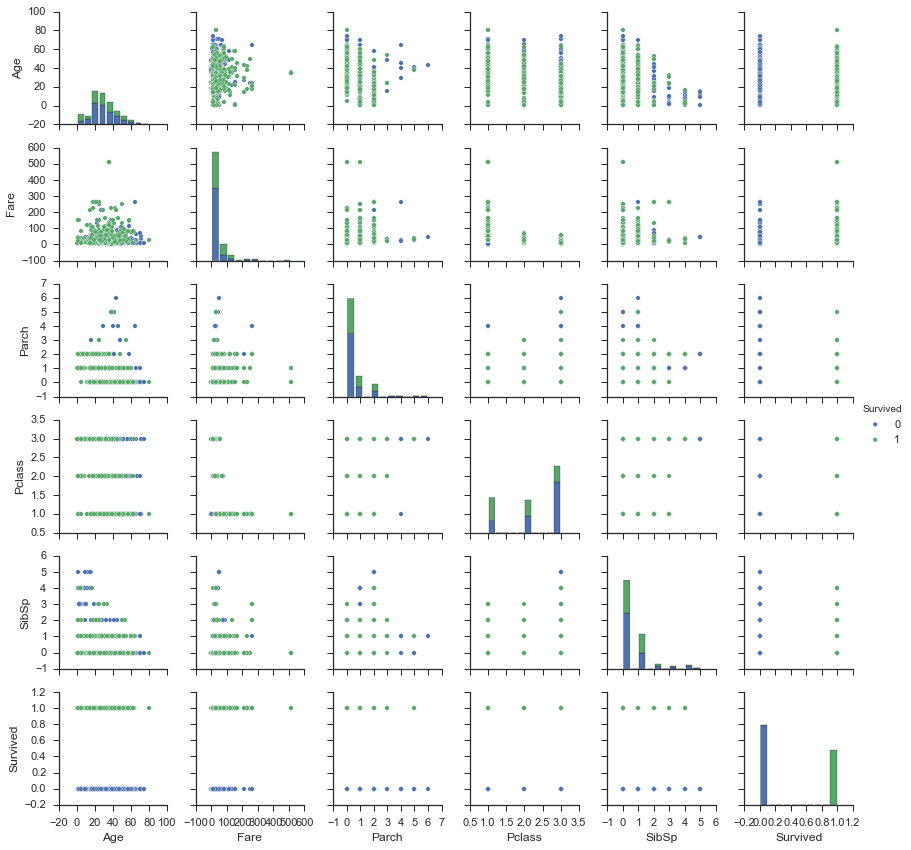

In [20]:
cols = [c for c in df.select_dtypes(include=['int64', 'float64']).columns.difference(['Cclass'])]
sns.pairplot(df[cols], size=2, hue="Survived")
# reference: seaborn docs at https://stanford.edu/~mwaskom/software/seaborn/examples/scatterplot_matrix.html

A few things can be highlighted from the scatterplots, from top left to bottom right:
- Older passengers in 3rd class were less likely to survive. We can speculate they were allocated into the lower parts of the ship, and having lower mobility had less chances of evacuating the ship
- Larger families, with many siblings/spouses and parents/children in 3rd class were also less likely to survive. We can also assume these are due to the challenges in evacuating a large group of people from the lower parts of the ship
- Although the effect of large families and old age are more proeminent in 3rd class, in general, as seen in the other distributions, older passengers and larger familiers were less likely to survive.
- The fare for 2nd and 3rd class had little difference, while the fare for 1st class was up to 5x higher.
- Younger passengers had more siblings/spouses and parent/children. Larger families were more concentrated in 3rd class. 
- The fare distribution is more or less equal amongst age. 

The analysis answers our 3rd question: the histogram for siblings/spouses and parents/children shows that most passengers had no family on board. It also gives a hint to the 4th question, regarding the average fare per class. Let's see it in detail:

(Pclass
 1    87.961582
 2    21.471556
 3    13.229435
 Name: Fare, dtype: float64, Pclass
 1    512.3292
 2     73.5000
 3     56.4958
 Name: Fare, dtype: float64)

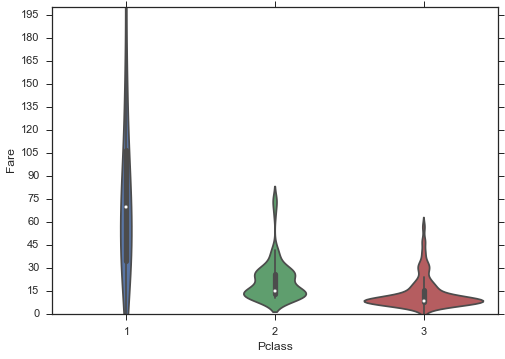

In [21]:
sns.violinplot(data=df, x='Pclass', y='Fare')
plt.yticks(np.arange(0,300,15))
plt.ylim(0,200)
df.groupby('Pclass')['Fare'].mean(), df.groupby('Pclass')['Fare'].max()

The average fare for 2nd and 3rd class are not so different, confirming our observation from the scatterplots. The prices are also more concentrated around the mean. On the other hand, 1st class tickets have an average 4x timers higher than 2nd class tickets, with a considerable number of outliers ranging from \$200 to over $500.

Moving on, I will plot a heatmap with the Pearson correlation coefficient between the variables:

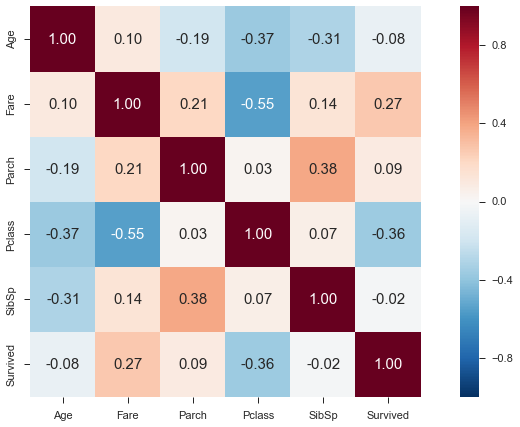

In [22]:
"""
note: Pearson's R is not the ideal approach for calculating correlation between binary or ordinal variables,
it is used here forward for simplicity and to have a rudimentary perspective on the data.
References: http://stats.stackexchange.com/questions/103801/is-it-meaningful-to-calculate-pearson-or-spearman
-correlation-between-two-boolea
"""
# reference: Python for Machine Learning book, chapter 11; seaborn docs

cm = np.corrcoef(df[cols].values.T)
plt.figure(figsize=(14, 7))
hm = sns.heatmap(cm,
                cbar=True,
                annot=True,
                square=True,
                fmt='.2f',
                annot_kws = {'size': 15},
                yticklabels=cols,
                xticklabels=cols)


Some observations from the heatmap:

* There is a high correlation between Siblings/Spouse and Parent/Children (0.41)
* There is a minor correlation between Age and number of siblings/spouse and parent/children (-0.23 and -0.17), which ratificates our observation done by analyzing scatterplots that younger passengers had larger families. 
* Passenger class and Fare are inversely correlated (-0.55), which is expected - 1st class had the higher fares. 
* There is no significant correlation between Age and Fare (0.10), also confirming one of the previous observations.
* Passenger class and Fare are good indicators of a passenger having survived or not, with -0.34 and 0.26 correlations respectively.


## Analyzing nominal variables

Let's take a more detailed look now at the categorical variables, including the ones we derived from the original data. I will particularly focus on how the categories have an impact on whether the passenger has survived or not. For that, I will use bar plots with color encodings.

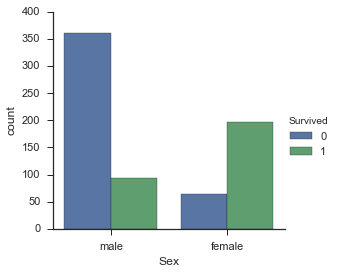

In [23]:
# For each category, I will plot the number of people that perished and the number of people that survived side by side
sns.factorplot(data=df, x='Sex', kind='count', hue='Survived', size=4)    

Sex has a clear influence on whether the passenger survived or not. Women had a much higher chance of surviving than men aboard the Titanic. We can even go further and calculate the Pearson correlation between the variables, since they are both binary:

In [24]:
# calculate Pearson's r
bin_sex = df['Sex'] == 'female'
stats.pearsonr(x=df['Survived'], y=bin_sex)

(0.53882559301463551, 5.2247099268013592e-55)

The correlation between them is 0.54, with a 2-tailed p-value of 1.406e-69, which is very low. Considering a significance level alpha of 0.05, we can conclude that the correlation between Sex and Survived variables is different than 0.  

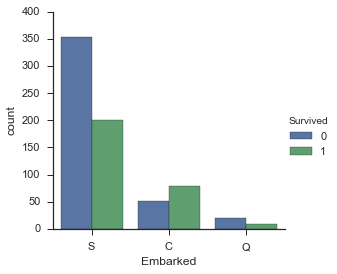

In [25]:
sns.factorplot(data=df, x='Embarked', kind='count', hue='Survived', size=4)    

In Embarked we can also see significant results. Embarked refers to the port where the passenger embarked (C = Cherbourg; Q = Queenstown; S = Southampton). Passengers who embarked in Cherbourg were more likely to survive than passengers who have embarked in either Queenstown and Southampton. Here again let's test the correlation.

In [26]:
# create a new variable, true or false, for passengers who embarked in Cherbourg
embarked_in_cherbourg= df['Embarked'] == 'C'
stats.pearsonr(x=df['Survived'], y=embarked_in_cherbourg)

(0.19360693204683369, 1.8513925808257593e-07)

The correlation value is lower, but considering a significance level of 0.05 we can also conclude that the correlation between Embarked_in_Cherbourg and Survived is different than 0. When preparing the data for Machine Learning, we can use a OneVsRest or OneVsAll approach and convert this column into three different binary columns.

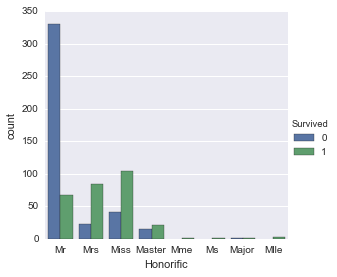

In [27]:
sns.set(font_scale=1.0)
sns.factorplot(data=df, x='Honorific', kind='count', hue='Survived', size=4)    

Here again we have relevant difference. Passengers with honorific of Mr. had lesser chance to survive than passengers with honorific Mrs. or Miss, confirming the observation made in the analysis of Sex variable. The additional information here is regarding the remaining honorifics - Master, for example, which precludes no particular gender, had a chance to survive much higher than the regular Mr. . This information is also valuable to a classifier algorithm and can be transformed using a OneVsRest approach

## Analyzing variables with an algorithmic approach

Another way to analyse the relevance of a variable is by using an algorithm approach, such as a decision tree or a logistic regression with L1 regularization. Considering Survived as the target variable, and the remaining features, let's build a decision tree to see which features have the greater impact in predicting the outcome. 

A seminal paper by Leo Breiman, who popularized Random Forest algorithms, argues in favor of using algorithmic approaches to analyse your data instead of trying to fit it into traditional data models that may not represent reality.

Statistical Modelling: The Two Cultures -> https://projecteuclid.org/euclid.ss/1009213726

We will use a Random Forest implemented in sklearn. A Random Forest is an ensemble approach that combines decision trees, using subsets of the data, to generate an optimal classifier. The scikit-learn implementation, in particular, "combines classifiers by averaging their probabilistic prediction, instead of letting each classifier vote for a single class." (sci-kit learn docs).

Before feeding the data into the classifer, let's filter out Name, which contains irrelevant information to the classifier since it is unique per observation, and convert categorical variables into dummy variables. At this point, I will remove variables Ticket, Surname and Cabin, for simplicity, since the number of categories would slow down the calculation. They might be relevant in future models to increase the accuracy of the predictor.

In [28]:
# selecting cols
labels = df['Survived']
feature_names = df.columns.difference(['Survived', 'Name', 'Ticket', 'Surname', 'Cabin', 'Cclass'])
features = df[feature_names]
features.dtypes

Age          float64
Embarked      object
Fare         float64
Honorific     object
Parch          int64
Pclass         int64
Sex           object
SibSp          int64
dtype: object

In [29]:
# convert categorical to dummy variables
features = pd.get_dummies(features, columns=['Embarked', 'Sex', 'Honorific'])
features.head()

,Age,Fare,Parch,Pclass,SibSp,Embarked_C,Embarked_Q,Embarked_S,Sex_female,Sex_male,Honorific_Major,Honorific_Master,Honorific_Miss,Honorific_Mlle,Honorific_Mme,Honorific_Mr,Honorific_Mrs,Honorific_Ms
PassengerId,,,,,,,,,,,,,,,,,,
1,22.0,7.2500,0,3,1,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,38.0,71.2833,0,1,1,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,26.0,7.9250,0,3,0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,35.0,53.1000,0,1,1,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
5,35.0,8.0500,0,3,0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [30]:
# using full data, without split for test data, since decision tree is not being used as predictor 
# but only to analyse the relevance of each variable
# not optimizing parameters as well
updated_feature_names = [col for col in features.columns]

from sklearn import ensemble
clf = ensemble.RandomForestClassifier(n_estimators=20, random_state=49)
clf.fit(features, labels)
feature_importances = zip(updated_feature_names, clf.feature_importances_)
sorted(feature_importances, key=lambda x:-x[1])

[('Fare', 0.24576830904627736),
 ('Age', 0.22589616444655972),
 ('Sex_male', 0.10666107946493127),
 ('Honorific_Mr', 0.095332294993600672),
 ('Pclass', 0.089666109682523171),
 ('Sex_female', 0.076738070831540731),
 ('SibSp', 0.060405340708653013),
 ('Parch', 0.032730642973964233),
 ('Honorific_Master', 0.015643351718632285),
 ('Honorific_Miss', 0.014124268762555126),
 ('Embarked_C', 0.010473773100123551),
 ('Honorific_Mrs', 0.0094129799294896659),
 ('Embarked_S', 0.0094045081008027245),
 ('Embarked_Q', 0.0071095927420749385),
 ('Honorific_Major', 0.00052713451015759896),
 ('Honorific_Mlle', 5.519537142623193e-05),
 ('Honorific_Ms', 5.1183616687733832e-05),
 ('Honorific_Mme', 0.0)]

In the result, we can see the features with greater relevance to determine if a passenger have survived or not are Fare, Age, and gender male (represented in Sex_male and Honorific_Mr). A lot of other variables also have considerable relevance, such as Passenger Class and Familiy members, and should not be discarded in predictive models. That answers ours 5th question regarding the impact of each variable on the passengers' chance of survival.

## Conclusion

In this project, we aimed to analyse Titanic dataset using many different approaches of data analysis. The goal of the data exploration was not only to answer the previously stated questions, but also to enlarge the perspective and discover new relationships which were not foreseen. 

Along the project we have answered the questions raised, which are reproduced here:

**What is the age distribution distribution of the passengers?**

We can see that the mean age is 29 years old, with a standard deviation of 14 years, a min of 0.4 (around 5 months old) and a max of 80. Most of the passengers are between 20 and 40 yers old. 

**How many different families were on board?**

Considering the dataset is complete, there were 667 different families onboard the Titanic.

** Was there a predominance of single passengers or large families? **

The histogram for siblings/spouses and parents/children shows that most passengers had no family on board

** What was the average fare for each class? **

The average fare for 2nd and 3rd class are not so different, confirming our observation from the scatterplots. The prices are also more concentrated around the mean. On the other hand, 1st class tickets have an average 4x timers higher than 2nd class tickets, with a considerable number of outliers ranging from \$200 to over $500.

** How does each variable impact on the chance of surviving? **

The features with greater relevance to determine if a passenger have survived or not are Fare, Age, and gender male (represented in Sex_male and Honorific_Mr). A lot of other variables also have considerable relevance, such as Passenger Class and Familiy members, and should not be discarded in predictive models


The results presented are by no mean statistically significant, and only indicate tentative findings, hence should be taken at their face value. A deeper statistical approach could be conducted to find the answer with the rigour that scientific endeavors requires.

Future reports can analyse deeper into some of the variables to gain more insight. One example is how the position of each cabin in the ship correlates with the chance of survival. We can also analyse the families composition, and verify if men that belonged to large families composed mostly by women had more or less chance to survive than passengers who were single. We can also infer nationality by family name and port of embarkation and see whether it had any impact on the passenger chance of survival. 